#Hessian Free Optimization on Deep Neural Networks

### By : 

#### Gundapu Nitish Kumar - AI22MTECH14004

#### Vishnu Vijay Tiwari - AI22MTECH14003 

### Importing packages

In [ ]:
import time
import math
import warnings
import torch as t
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
warnings.filterwarnings("ignore")

### Creating Dataset

In [ ]:
np.random.seed(10)
import numpy as np


def one_hot_encoding(Z):
    '''
    input : vector
    output : encoded vector
    function takes a vector input and gives one hot encoded vector as output
    '''
    Z1 = np.zeros((Z.size,2))
    for i,a in enumerate(Z):
        if a == 0:
            Z1[i] = np.array([0,1])
        else:
            Z1[i] = np.array([1,0])
    return Z1

def one_hot_decoding(a2):
    '''
    input : encoded vector
    output : vector
    function takes a encoded vector input and gives decoded vector as output
    '''
    Ytp = []
    for a in a2:
        if a[0] > a[1]:
            Ytp.append(1)
        else:
            Ytp.append(0)
    return np.array(Ytp)


def create_dataset(N):
    '''
    input : N
    output : gives X,Y samples of datset
    function takes n input and gives n 4D (x,y) sanples as output
    '''
    X = np.random.rand(N,4)
    Y = np.zeros(N)

    #creating n datapoints for a condtion
    for a in range(N):
        if X[a,0] - X[a,1] + X[a,3] >=0 :
            Y[a] = 1
    Y = np.array([[a] for a in Y])
    print(Y.size)

    #one hot encoding the Y values
    Y = one_hot_encoding(Y)
    return X,Y

### Plotting the dataset

1000


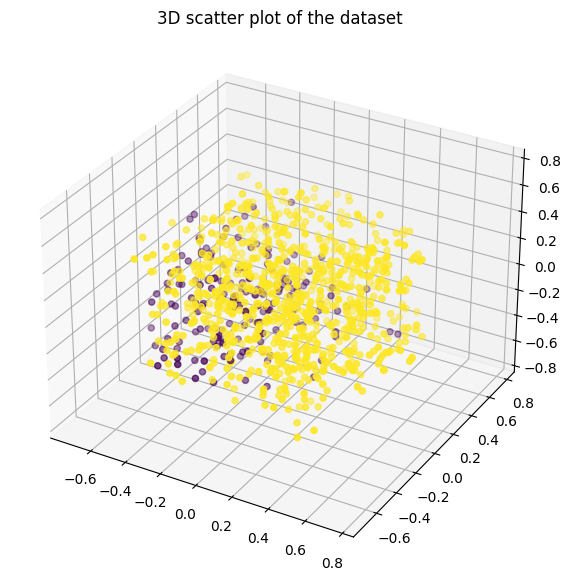

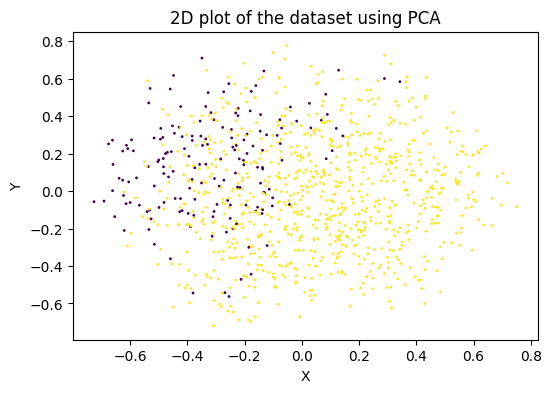

In [ ]:
def get_pca(df,n1):
    '''
    input: dataset , n-components
    output : dataset
    function takes dataset as input and apply pca fro n-components
    '''
    pca = PCA(n_components = n1, random_state = 7)
    return pca.fit_transform(df)


def get_2dplot(df,labels):
    '''
    input : 2d dataset
    output : plot
    function takes 2d dataset as input and gives the Plot
    '''
    df = get_pca(df,2)
    fig = plt.figure(figsize=(6,4))
    x = df[:,0]
    y = df[:,1]

    #getting the scatter plot
    plt.scatter(x,y,s=1,c=labels)
    plt.xlabel("X")
    plt.ylabel('Y')
    plt.title("2D plot of the dataset using PCA")
    plt.show()

def get_3dplot(data,labels):
    '''
    input : 3d dataset
    output : plot
    function takes 3d dataset as input and gives the Plot
    '''
    data = get_pca(data,3)
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    #getting the 3-d scatter plot
    ax.scatter3D(x, y, z, c = labels)
    plt.title("3D scatter plot of the dataset")

    # show plot
    plt.show()

x,y = create_dataset(1000)
get_3dplot(x,labels = one_hot_decoding(y))
get_2dplot(x,labels = one_hot_decoding(y))

### Splitting the dataset for traning and testing

In [ ]:
Xtr, Xte, Ytr, Yte = tts(x,y,test_size=0.25,shuffle=True)

### Defining an accuracy function

In [ ]:
def accuracy(net,xtest,ytest):
    '''
    input : net,test data
    output : accuracy
    function takes network and test data as input and gives the accuracy 
    for the net
    '''
    ypred = []

    #forward passing all samples in test data
    for a in xtest:
        a = t.tensor(a).to(t.float32)
        u = net.forward(a)
        ypred.append([u[0].item(),u[1].item()])

    #one hot decoding the test data for accuracy
    ypred = np.array(ypred)
    ypred = one_hot_decoding(ypred)
    ytest = one_hot_decoding(ytest)
    return np.mean(ypred == ytest)*100

### Defining Neural Network architecture

In [ ]:
class neural_net():
    '''
    this class is a simples neural network with 2 layers -> 1 input , 1 output layer
    it has mean square loss function and sigmoid as activation function
    '''
    def __init__ (self,ins,hs,lr):
        '''
        defining weights and learning rate from constructor
        '''
        self.W = t.rand(size=(ins,hs)).requires_grad_()
        self.lr = lr

    def Sigmoid(self,x):
        return 1/(1+t.exp(-1*x))

    def forward(self,X):
        '''
        forward pass of neural network
        '''
        z1 = t.matmul(X,self.W)
        return self.Sigmoid(z1)
    
    def parameters(self):
        '''
        returns parameters
        '''
        return [self.W]
    
    def loss_fn(self,x,y):
        return t.norm(t.matmul(x,self.W)-y)**2

    def grad(self,x,y):
        '''
        returns gradients of y wrt x,uses autograd from pytorch
        '''
        return t.autograd.grad(self.loss_fn(x,y),self.parameters(),create_graph=True)


    def grads_flatten(self,x,y,v=0,e=1):
        '''
        returns the flattened vector of all gradients of the parameter
        it is calculated to tackle different sizes of the parameters while computing hessian
        '''
        grads = t.cat([a.view(-1) for a in self.grad(x,y)])
        return (grads + v*e)*e

    def hessian_flatten(self,x,y,tol):
        '''
        returns the gradients of the flattend gradient from grads_flatten function
        it is calculated to tackle different sizes of gradients of parameters while computing hessian
        '''
        grads = self.grads_flatten(x,y)
        H = t.zeros((grads.size(0), grads.size(0)))

        #calculating gradients for the flattend gradients
        for i in range(grads.size(0)):
            res = t.autograd.grad(grads[i],self.parameters(),retain_graph=True)[0]
            H[i] = t.cat([a.view(-1) for a in res])
        H1 = H.detach().numpy()

        #adding tol to ignore the error case where Hessian is Singular
        H1 = H1 + np.eye(H.shape[0])*tol

        #adding with its transpose to make it symmetric
        return (H1 + H1.T)*0.5
    
    def HVP(self,x,y,v,e):
        '''
        returns the hessian vector product of the nn
        '''
        #gradient of vector x
        grads = self.grads_flatten(x,y)
        #gradient of vector x+v*e
        grads1 = self.grads_flatten(x,y,v,e)
        return (grads1 - grads)*(1/e)

    def update_params_hessian(self,w):
        '''
        Updates the parameter for hessian function
        '''
        w = t.from_numpy(w.reshape(self.W.size()))
        self.W.data = w.data
    

### Implementation of Stochastic Gradient Descent

In [ ]:
def SGD(net,xtrain,ytrain,epochs):
    '''
    input : net, training data , epochs
    output : loss array , net
    function takes neural network , training data as input and gives the trained network 
    as output using SGD and the loss calculated at each epoch
    '''
    res_array = []

    #running for n epochs
    for i in range(epochs):
        loss1 = 0

        #running for each data point in training data
        for x,y in zip(xtrain,ytrain):
            X = t.tensor(x).to(t.float32)
            Y = t.tensor(y).to(t.float32)

            # calculating loss and gradients
            loss = net.loss_fn(X,Y)
            grads = net.grad(X,Y)

            #updating parametrs
            for param , w in zip(net.parameters(),grads):
                param.data -= (net.lr)*(w.data)
            
            loss1 += loss.item()
        res_array.append(loss1)

        #printing loss for every 2 iterations
        if i%2 == 0:
            print(f"Training loss at iteration {i} is {loss1/len(ytrain)}")
    return net,res_array

### Implementation of Newton Method

In [ ]:
def newton_update(net,Xtr, Ytr,epochs,tol):
    '''
    input : net, training data , epochs
    output : loss array , net
    function takes neural network , training data as input and gives the trained network 
    as output using Newtons Method and the loss calculated at each epoch
    '''
    res_array = []
    
    #running for n epochs
    for a in range(epochs):
        loss1 = 0

        #running for each data point in training data
        for x,y in zip(Xtr,Ytr):
            try:
                x = t.tensor(x).to(t.float32).unsqueeze(0)
                y = t.tensor(y).to(t.float32).unsqueeze(0)

                #calculating loss 
                loss = net.loss_fn(x,y)

                #calculating flattend hessian 
                H = net.hessian_flatten(x,y,tol)

                #calculating flattend gradients
                G = net.grads_flatten(x,y).detach().numpy()

                #calculating update at a data point
                update = -1*np.linalg.inv(H) @ G

                #updating the parameters by resizing the update wrt parameters
                offset = 0
                for param in net.parameters():
                    size = param.numel()
                    #resizing and adding wrt parameter
                    param.data += (net.lr)*t.from_numpy(update[offset:offset+size]).reshape(param.size())
                    offset += size

                loss1 += loss.item()
            except:
                continue
        
        res_array.append(loss1)
        #printing loss for every 2 iterations
        if a%2 == 0:
            print(f"Training loss at iteration {a} is {loss1/len(Ytr)}")
    return net,res_array

### Implementation of Hessian Free Optimization

In [ ]:
def hess_free_update(net,Xtr,Ytr,epochs,e):
    '''
    input : net, training data , epochs
    output : loss array , net
    function takes neural network , training data as input and gives the trained network 
    as output using Hessian free Optimization Method and the loss calculated at each epoch
    '''
    res_array = []

    #running for n epochs
    for i in range(epochs):
        loss1 = 0

        #running for each data point in training data
        for x,y in zip(Xtr,Ytr):
            try:
                x = t.tensor(x).to(t.float32).unsqueeze(0)
                y = t.tensor(y).to(t.float32).unsqueeze(0)

                #calcualting loss
                loss = net.loss_fn(x, y)
                loss1 += loss.item()

                #if loss is less , skip the data point
                if loss.item()<1e-5 or math.isnan(loss.item()):
                    break

                #calculating the gradient
                p = -1*net.grads_flatten(x,y)
                r = p.clone()

                #Updating the parameters using linear search
                for _ in range(2):

                    #computing the hessian vector product
                    Ap = net.HVP(x,y,p,e)

                    #upding alpha
                    alpha = t.dot(r, r) / t.dot(p, Ap)
                    
                    #Updating paramters wrt size
                    param = t.cat([net.parameters()[0].view(-1)])
                    param += alpha*p*(net.lr)
                    net.update_params_hessian(param.detach().numpy())
                    
                    #calcualting beta and updating gradients
                    r1 = r-alpha*Ap
                    beta = t.dot(r1, r1) / t.dot(r, r)
                    p = -r + beta * p
                    r = r1
                    
            except:
                continue
        res_array.append(loss1)
        #printing loss for every 2 iterations
        if i%2 == 0:
            print(f"Training loss at iteration {i} is {loss1/len(Ytr)}")
    return net,res_array


### Training and testing the networks

In [ ]:
lr = 0.2
epochs=10

#training and testing for SGD
start = time.time()
net = neural_net(4,2,lr)
net , res_array = SGD(net,Xtr,Ytr,epochs)
end = time.time()
print(f"Accuracy for SGD : {accuracy(net,Xte,Yte)}")
print(f"Time taken for running algorithm : {round(-1*start+end,2)} sec \n")

#training and testing for Newtons method
start = time.time()
net1 = neural_net(4,2,lr)
net1 , res_array1 = newton_update(net1,Xtr,Ytr,epochs,1)
end = time.time()
print(f"Accuracy for Newtons Method : {accuracy(net1,Xte,Yte)}")
print(f"Time taken for running algorithm : {round(-1*start+end,2)} sec \n")

#training and testing for Hessian free Optimization
start = time.time()
net2 = neural_net(4,2,lr)
net2,res_array2 = hess_free_update(net2,Xtr,Ytr,epochs,0.1)
end = time.time()
print(f"Accuracy for Hessian Free : {accuracy(net2,Xte,Yte)}")
print(f"Time taken for running algorithm : {round(-1*start+end,2)} sec \n")


Training loss at iteration 0 is 0.27183397875912485
Training loss at iteration 2 is 0.26171156122919637
Training loss at iteration 4 is 0.26171156122919637
Training loss at iteration 6 is 0.26171156122919637
Training loss at iteration 8 is 0.26171156122919637
Accuracy for SGD : 62.8
Time taken for running algorithm : 2.54 sec 

Training loss at iteration 0 is 0.24239578722966446
Training loss at iteration 2 is 0.22046224806729395
Training loss at iteration 4 is 0.2204622467328639
Training loss at iteration 6 is 0.22046224381406015
Training loss at iteration 8 is 0.2204622447078194
Accuracy for Newtons Method : 93.60000000000001
Time taken for running algorithm : 48.96 sec 

Training loss at iteration 0 is 0.2644890903486812
Training loss at iteration 2 is 0.20333877442916856
Training loss at iteration 4 is 0.2033388193079154
Training loss at iteration 6 is 0.2033388494242099
Training loss at iteration 8 is 0.2033388502378366
Accuracy for Hessian Free : 96.39999999999999
Time taken for 

### Plotiing the Results

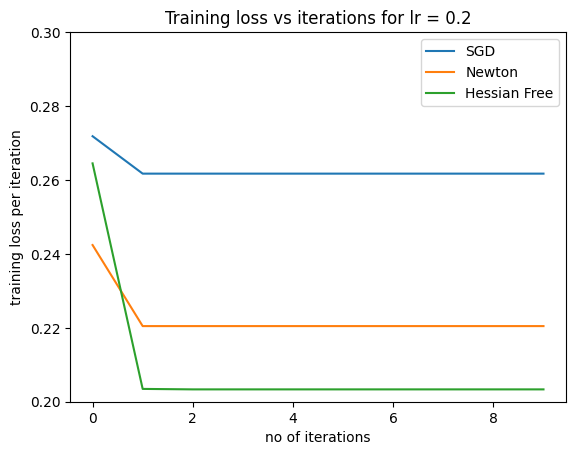

In [ ]:
plt.plot(range(epochs),np.array(res_array)/len(Ytr),label="SGD")
plt.plot(range(epochs),np.array(res_array1)/len(Ytr),label="Newton")
plt.plot(range(epochs),np.array(res_array2)/len(Ytr),label="Hessian Free")
plt.xlabel("no of iterations")
plt.ylabel("training loss per iteration")
plt.ylim(0.2,0.3)
plt.title("Training loss vs iterations for lr = 0.2")
plt.legend()
plt.show()